# Import Libraries & Data

Documentation: https://pyod.readthedocs.io/en/latest/

In [1]:
!pip install pyod --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor #simpler and faster compared to alternative (below)
from enum import auto
from pyod.models.lof import LOF #Local Outlier Factor
from pyod.models.abod import ABOD #Angle based outlier detection
from pyod.models.cblof import CBLOF #Clustering-Based Local Outlier Factor
from pyod.models.pca import PCA #Principal Component Analysis (the sum of weighted projected distances to the eigenvector hyperplanes)
from pyod.models.knn import KNN #K Nearest Neighbors (use the distance to the kth nearest neighbor as the outlier score)

In [22]:
path = '/content/data_outlier.csv'
data = pd.read_csv(path)

Visualize the data.  We seek to find the outliers using various methods.

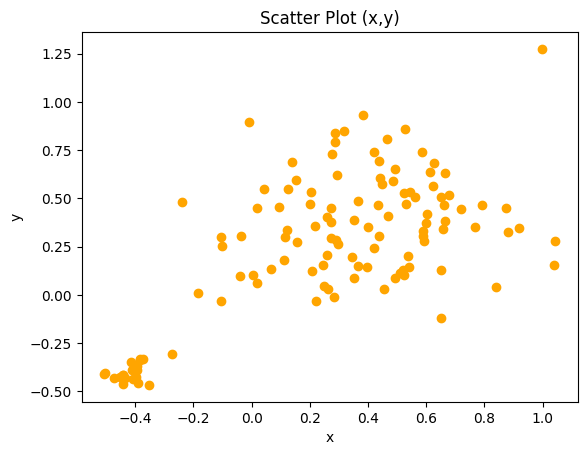

In [4]:
plt.scatter(data['x'], data['y'], color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot (x,y)');

# Apply Each Method

Save all results in the dictionary below:

In [5]:
results = {}
def visualize_outliers(method, results, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(results[method]['outlier_data']['x'], results[method]['outlier_data']['y'], color='red', label='outliers')
    ax.scatter(results[method]['inlier_data']['x'], results[method]['inlier_data']['y'], color='green', label='inliers')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{method} results w/ outliers & inliers')
    ax.legend()
    return ax

### KNN

In [6]:
knn = KNN(n_neighbors=5, method='mean', contamination=8/120)
fit = knn.fit(data)
bool_musk = fit.labels_ > 0 #naive hard-label approach.
outlier_data = data.loc[bool_musk]
inlier_data = data.loc[~bool_musk]
results['KNN'] = {'outlier_data':outlier_data,
                  'inlier_data': inlier_data
}

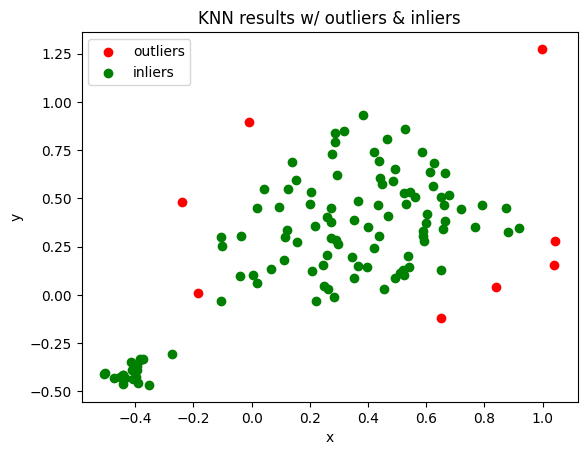

In [7]:
visualize_outliers('KNN', results);

## LOF

In [8]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=8/120) #can also use 'auto'
predict = lof.fit_predict(data)
bool_musk = predict < 0 #naive hard-label approach.
outlier_data = data.loc[bool_musk]
inlier_data = data.loc[~bool_musk]
results['LOF'] = {'outlier_data':outlier_data,
                  'inlier_data': inlier_data
}

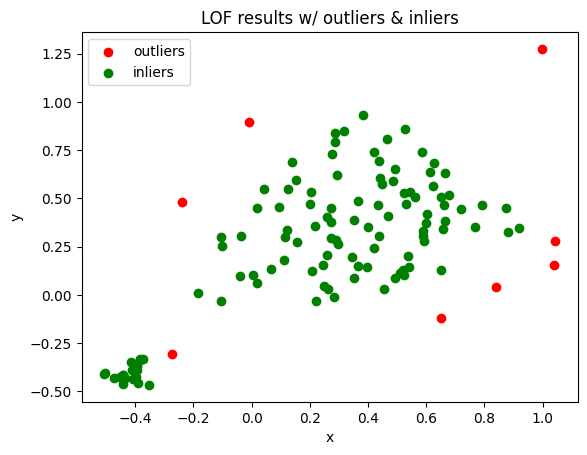

In [9]:
visualize_outliers('LOF', results);

## CBLOF

Visualize the changes of CBLOF based on the number of clusters.

In [10]:
def cblof_clusters(cluster_lb, cluter_ub): #will produce error if cluster_lb is too small.
  temp_results = {}
  figures = []
  for i in range(cluster_lb, cluter_ub):
    cblof = CBLOF(contamination=8/120, n_clusters=i)
    fit = cblof.fit(data)
    bool_musk = fit.labels_ > 0 #naive hard-label approach.
    outlier_data = data.loc[bool_musk]
    inlier_data = data.loc[~bool_musk]
    temp_results[f'CBLOF ; num_clusters = {i}'] = {'outlier_data':outlier_data,
                      'inlier_data': inlier_data
}

    fig = plt.figure(figsize=(6, 3))
    visualize_outliers(f'CBLOF ; num_clusters = {i}', temp_results)
    figures.append(fig)

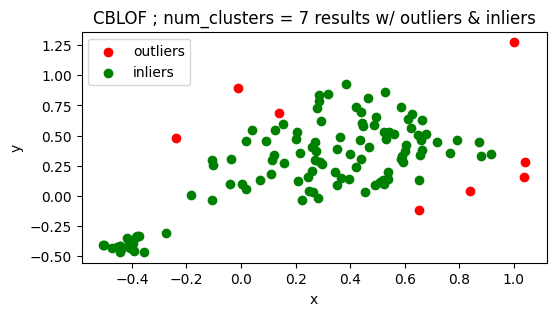

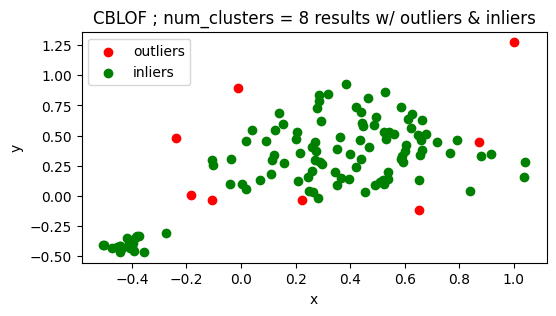

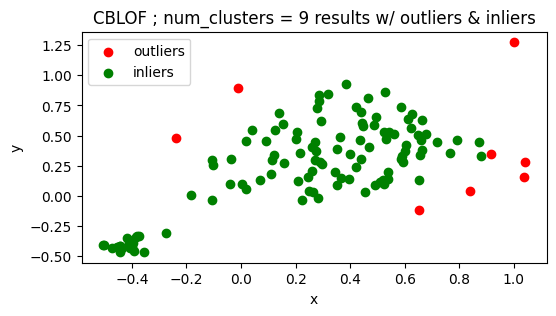

In [11]:
cblof_clusters(cluster_lb = 7, cluter_ub = 10)

Let us use default # of clusters for now by not specifying the argument.

In [12]:
cblof = CBLOF(contamination=8/120)
fit = cblof.fit(data)
bool_musk = fit.labels_ > 0
outlier_data = data.loc[bool_musk]
inlier_data = data.loc[~bool_musk]
results[f'CBLOF'] = {'outlier_data':outlier_data,
                     'inlier_data': inlier_data}

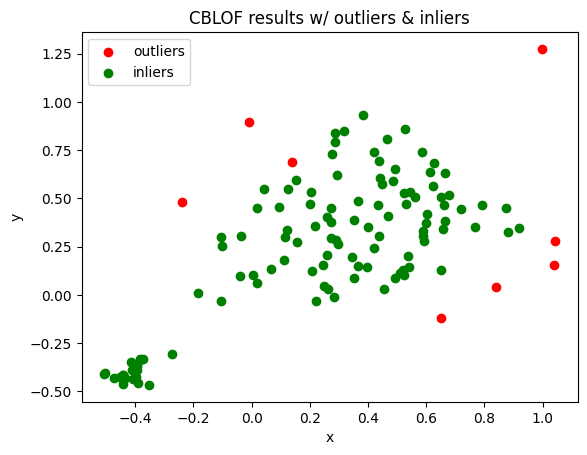

In [13]:
visualize_outliers('CBLOF', results); #looks good.

## ABOD

In [14]:
abod = ABOD(contamination=8/120, n_neighbors=5)
fit = abod.fit(data)
bool_musk = fit.labels_ > 0 #naive hard-label approach.
outlier_data = data.loc[bool_musk]
inlier_data = data.loc[~bool_musk]
results['ABOD'] = {'outlier_data':outlier_data,
                  'inlier_data': inlier_data
}

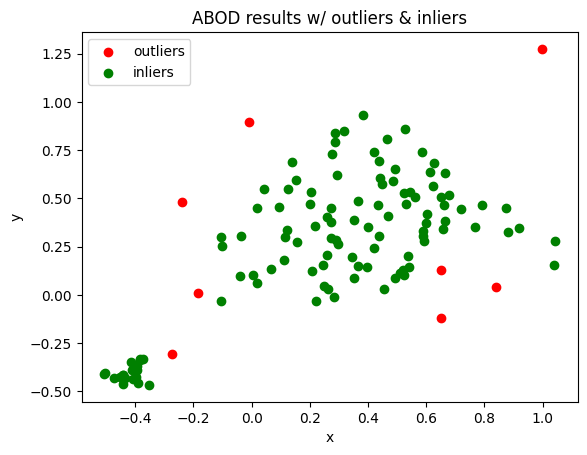

In [15]:
visualize_outliers('ABOD', results);

## PCA

In [16]:
pca = PCA(contamination=8/120)
fit = pca.fit(data)
bool_musk = fit.labels_ > 0 #naive hard-label approach.
outlier_data = data.loc[bool_musk]
inlier_data = data.loc[~bool_musk]
results['PCA'] = {'outlier_data':outlier_data,
                  'inlier_data': inlier_data
}

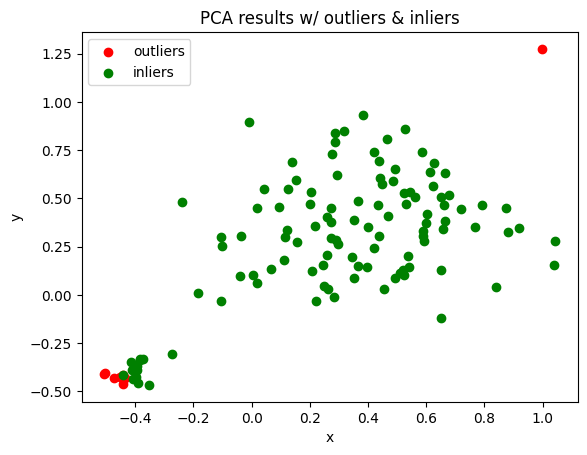

In [17]:
visualize_outliers('PCA', results);

# Compare Methods

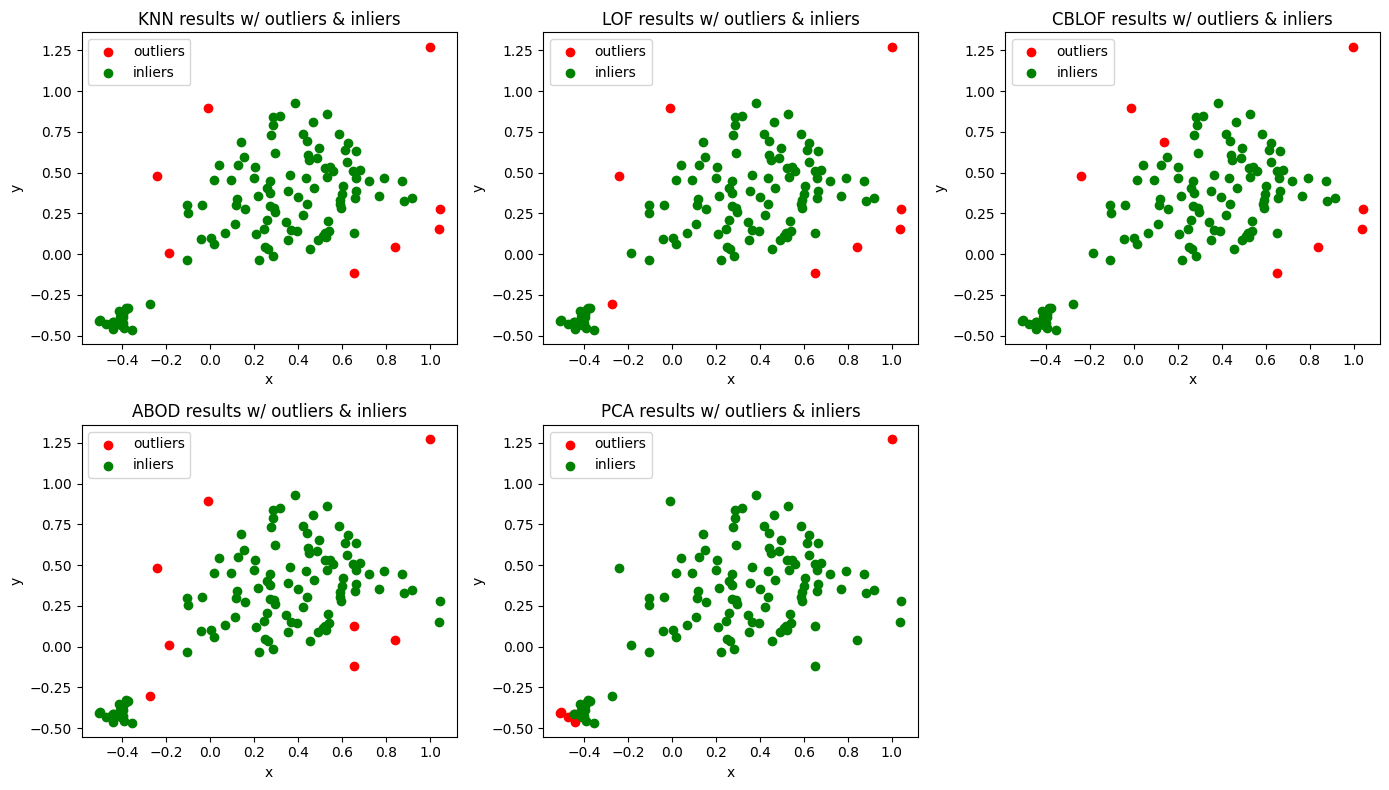

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
methods = list(results.keys())
for i, method in enumerate(methods[:5]):
    visualize_outliers(method, results, ax=axes[i])
axes[5].set_visible(False)
plt.tight_layout()
plt.show()

Results:

**(1)** KNN, LOF, and CBLOF are very consistent, identifying the same 7-8 outliers; they detect both the cluster in the bottom left and several scattered points in the main distribution.

**(2)** ABOD (Angle-Based Outlier Detection) shows fewer outliers than KNN/LOF/CBLOF, focusing mainly on peripheral points. This makes sense as ABOD uses angular relationships between points rather than density, making it better for high-dimensional data but potentially less sensitive to certain outlier patterns in 2D.

**(3)** PCA clearly performs worst, identifying only points in the bottom left cluster as outliers while missing scattered outliers elsewhere. This confirms that PCA is poorly suited for general outlier detection - it's primarily designed for dimensionality reduction, not anomaly detection.